<a href="https://colab.research.google.com/github/elhamod/BA865-2024/blob/main/hands-on/Audio_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, you will learn how to deal with audio data.

In [1]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch


## Data Downloading

Next, we'll download and unzip the dataset of speech commands from tensorflow: http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

Below we load the data and print the number of examples.

In [2]:
import torch
from pathlib import Path

def getData(sampling=16000, use_MFCC=True, n_mfcc=12, number_of_samples={'yes':2000, 'no': 2000}, noise=.0, normalize=True):
  #download the data
  my_file = Path("/content/speech_commands/")
  if not my_file.exists():
    !wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
    !mkdir speech_commands
    !tar -C ./speech_commands -xf speech_commands_v0.01.tar.gz

  directory = 'speech_commands/'
  all_wavs = [] # The inputs
  all_labs = [] # The outputs

  # create the dataset as arrays
  for label in number_of_samples.keys():
      wavs = [f for f in os.listdir(directory + label) if f.endswith('.wav')]
      for indx, wav in enumerate(wavs):
          samples, sample_rate = librosa.load(directory + label + '/' + wav, sr = 16000)
          samples = librosa.resample(samples, orig_sr=16000, target_sr=sampling) # Resamples the audio to possibly lower sampling rate: https://librosa.org/doc/main/generated/librosa.resample.html

          if noise != 0:
            samples = samples+noise*np.random.randn(*samples.shape)
            samples = samples/max(samples)

          if number_of_samples[label] > indx:
            if(len(samples)== sampling): # makes sure all samples have the same length
                all_wavs.append(samples)
                all_labs.append(label)

  # applying MFCC
  if use_MFCC:
    all_wavs = librosa.feature.mfcc(y=np.array(all_wavs), sr=sampling, n_mfcc=n_mfcc)
  else:
    all_wavs = np.array(all_wavs)

  all_wavs = torch.tensor(all_wavs).float()
  if not use_MFCC:
    all_wavs = all_wavs.unsqueeze(-1)

  # Output encoding
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  all_labs_encoded = le.fit_transform(all_labs)
  all_labs_encoded = torch.LongTensor(all_labs_encoded)

  print("Total number of samples:", len(all_wavs))

  return all_wavs, all_labs_encoded

In [3]:
### Some data parameters

# Sampling (lower means less crisp audio)
sampling = 400 # Sampling rate (e.g., 16000). Smaller (e.g., 400 seems to work better)

# MelSpectogram params: convert raw data to frequency domain
use_MFCC = False
n_mfcc = 12 # input audio data size (higher -> more crisp sound) (e.g. 12)

# Other data params
number_of_samples = {'yes':2000, 'no': 2000} # We will try to classify between two classes. This defines the number of samples per class.
noise = 0. # If not zero, it makes the audio proportionally noisier (range: 0-1)

In [4]:
audio_data, audio_label = getData(sampling=sampling, use_MFCC=use_MFCC, n_mfcc=n_mfcc, number_of_samples=number_of_samples, noise=noise)

--2024-04-23 18:28:09--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.196.207, 142.250.98.207, 142.251.162.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.196.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  95.9MB/s    in 16s     

2024-04-23 18:28:25 (89.7 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

Total number of samples: 3587


In [5]:
audio_data.shape

torch.Size([3587, 400, 1])

Playing an example

In [6]:
indx_to_play = 0

# Only works if MFCC is not used (i.e., only works with raw audio). It also won't work if the sampling rate is too low (i.e., less than 4000).
print(audio_label[indx_to_play].item())
ipd.Audio(audio_data[indx_to_play].squeeze(),rate=sampling,autoplay=True)

1


## Build the model

In [7]:
def get_accuracy(dataloader, model):
  acc = 0

  with torch.no_grad():
      for audios, labels in dataloader:
          if use_cuda:
            audios = audios.cuda()
            labels = labels.cuda()

          outputs = model(audios)

          # Update accuracy for this batch
          acc = acc + torch.sum(torch.argmax(outputs, axis=1) == labels)


      # Compute the accuracy
      acc = acc/len(dataloader.dataset) # normalizes

      return acc


In [8]:

def get_loss(loader):
  with torch.no_grad(): # Anything under torch.no_grad will be calculated with no gradients. Can only be used for testing, not training!

    loss = 0
    for i, (audios, labels) in enumerate(loader): # The batches.
          # step1: Move data to cuda. Make sure the model is on cuda too!
          if use_cuda:
            audios = audios.cuda()
            labels = labels.cuda()

          # step2: Forward pass
          outputs = model(audios)

          # step 3: calculate the loss.
          loss = loss + audios.shape[0] * criterion(outputs, labels.view(-1))
    return loss/ len(loader.dataset)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=10, stride=2, padding=1)
        self.bn1 = nn.BatchNorm1d(16)

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=1)
        self.bn2 = nn.BatchNorm1d(32)

        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride=2, padding=1)
        self.bn3 = nn.BatchNorm1d(64)

        linear_in_size = 3200 # will be different for different sequence lengths, which is a drawback of CNNs compared to RNNs.
        self.fc2 = nn.Linear(linear_in_size, num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.flatten(x, 1)  # Flatten the tensor for the fully connected layer
        x = self.fc2(x)
        return x

In [10]:
import torch
import torch.nn as nn

# The following model uses LSTMs: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
## LSTMs are very similar to vanilla RNNs but with better convergence properties.
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=False):
        super(LSTM_model, self).__init__()
        self.bidirectional = bidirectional
        self.hidden_size = hidden_size

        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
        self.fc1 = nn.Linear((2 if self.bidirectional else 1)*self.hidden_size, 10)
        self.fc2 = nn.Linear(10, output_size)

    def forward(self, x):
        x, (h, c) = self.lstm1(x)
        h = torch.permute(h, (1,0,2)) # Put the batch dimension first.

        # take the embedding of the last layer.
        if self.bidirectional:
          h = h[:, -2:, :].reshape((-1, 2*self.hidden_size)) # if bidirectional, the size is twice as large
        else:
          h = h[:, -1, :]

        x = self.fc1(h)
        x = self.fc2(x)
        return x


##Training

In the next section, you will define your experiment's parameters and model's hyperparameters as flags here. Use these flags in your code so you can switch between experiemnts easily.

In [11]:
use_cuda = torch.cuda.is_available()

# Data
batch_size = 32 #(e.g., 32)

# optimizer
lr= 1e-3
epochs=200

# model
model_name = "RNN" #"CNN" # "RNN"
hidden_size = 50 # hn for the RNN (or LSTM) (e.g., 10)
num_layers = 3 # Number of layers for RNN (or LSTM) (e.g. 3)

In [12]:
audio_data.shape

torch.Size([3587, 400, 1])

### Data Loading

In [13]:
from torch.utils.data import DataLoader
import torch
from torchvision import transforms

def getDataLoaders(audio_data, audio_label, batch_size):
  # # normalization
  audio_data_mean = audio_data.mean(1).unsqueeze(1)
  audio_data_std = audio_data.std(1).unsqueeze(1)
  audio_data_transformed = (audio_data - audio_data_mean)/ audio_data_std

  hist = torch.histogram(audio_data_transformed)

  plt.plot(hist.bin_edges[:-1], hist.hist, color="r")


  # Load the data loaders
  my_dataset = torch.utils.data.TensorDataset(audio_data_transformed, audio_label)
  train_set, val_set = torch.utils.data.random_split(my_dataset, [0.8, 0.2])

  train_loader = DataLoader(dataset=train_set, batch_size=batch_size,  shuffle=True)
  val_loader = DataLoader(dataset=val_set, batch_size=batch_size,  shuffle=False)

  return train_loader, train_set, val_loader, val_set

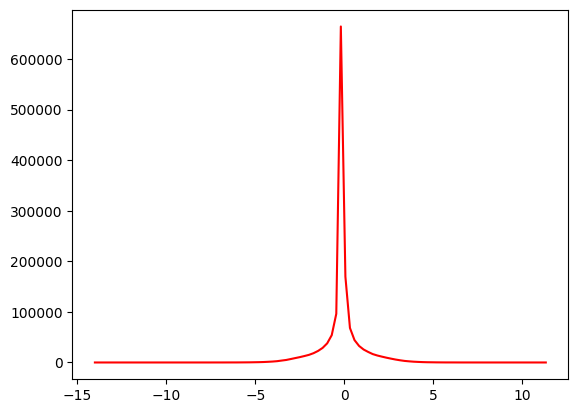

In [14]:
train_loader, train_set, val_loader, val_set = getDataLoaders(audio_data, audio_label, batch_size)

The data is properly scaled.

Here is the sample's shape for confirmation.

In [15]:
train_set[0][0].shape

torch.Size([400, 1])

## Classification

In [16]:
!pip install torchinfo

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

# Create an instance of the RNN classification model
input_size = train_set[0][0].shape[-1]
num_classes = 2

if model_name == "RNN":
  model = LSTM_model(input_size, hidden_size, num_layers, num_classes)
elif model_name == "CNN" and use_MFCC==False:
  model = CNNClassifier(num_classes)
else:
  raise "Model not found"

print(model)
print(summary(model, train_set[0][0].unsqueeze(0).shape))


if use_cuda:
  model = model.cuda()

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.9) #(e.g., factor=0.5)

best_val_acc = 0
for epoch in range(epochs): # The epochs.
    for i, (audios, labels) in enumerate(train_loader): # The batches.
        # step 1: Zero out the gradients.
        optimizer.zero_grad()

        # step 1.1 move data to cuda. Make sure the model is on cuda too!
        if use_cuda:
          audios = audios.cuda()
          labels = labels.cuda()


        # step2: Forward pass
        outputs = model(audios)

        # step 3: calculate the loss.
        loss = criterion(outputs, labels.view(-1))

        # step 4: Backward pass
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0) # You could add gradient clipping to fight an exploding gradient problem.
        optimizer.step()

    scheduler.step(get_loss(val_loader))

    if epoch %1 == 0:
      current_val_acc = get_accuracy(val_loader,model).item()
      if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
      current_train_acc = get_accuracy(train_loader,model).item()
      print(f"Epoch {epoch + 1} - acc: {current_train_acc:.4f}, best_val_acc: {best_val_acc:.4f}")






LSTM_model(
  (lstm1): LSTM(1, 50, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=50, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)
Layer (type:depth-idx)                   Output Shape              Param #
LSTM_model                               [1, 2]                    --
├─LSTM: 1-1                              [1, 400, 50]              51,400
├─Linear: 1-2                            [1, 10]                   510
├─Linear: 1-3                            [1, 2]                    22
Total params: 51,932
Trainable params: 51,932
Non-trainable params: 0
Total mult-adds (M): 20.56
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.21
Estimated Total Size (MB): 0.37
Epoch 1 - acc: 0.5031, best_val_acc: 0.5286
Epoch 2 - acc: 0.5031, best_val_acc: 0.5286
Epoch 3 - acc: 0.5031, best_val_acc: 0.5286
Epoch 4 - acc: 0.5031, best_val_acc: 0.5286
Epoch 5 - acc: 0.5031, best_val_acc: 0.5286
Epoch 6 - acc: 0.503

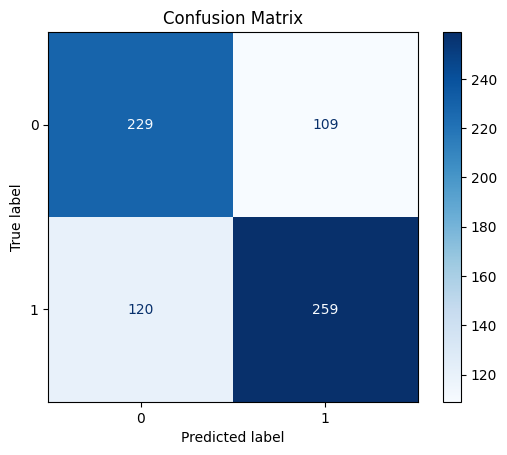

In [18]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()  # Set the model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get predicted class labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format=".0f")
plt.title("Confusion Matrix")
plt.show()


**Additional Questions:**

- Can you add an RNN/LSTM model that works on MFCC features?
- Can you add a CNN model that works on MFCC features?